In [1]:
import torch
from torchinfo import summary
import torch.optim as optim
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from piq import ssim


from utils.metrics import validation_scores
from models.completion.HVAE import ConditionalHierarchicalVAE
from utils.datasets import MNIST_SR_completion
from utils.utils import gaussian_kl


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
num_epochs = 100
batch_size = 512
scalefactor = 2

path = f"E:/GNN/experiments/trained_models/HVAE_MNIST_{scalefactor}x_completion_ssim.pth"

latent_dims = [64,128,256]
condition_dims = [32, 64]
channels = [16, 32, 64, 128]
cond_channels = [16, 32]
in_channels = 1
cond_base_width = 32 // scalefactor
model = ConditionalHierarchicalVAE(in_channels=in_channels,
                          latent_dims=latent_dims,
                          channels=channels,
                          cond_channels=cond_channels,
                          condition_dims=condition_dims,
                          cond_base_width=cond_base_width
                          ).to(device)
print(model.sample(torch.randn(1, in_channels, cond_base_width, cond_base_width).to(device)).shape)
summary(model, input_size=[(1, in_channels, 32, 32), (1, in_channels, cond_base_width, cond_base_width), (1, in_channels, 32, 32)])

torch.Size([1, 1, 32, 32])


Layer (type:depth-idx)                        Output Shape              Param #
ConditionalHierarchicalVAE                    [1, 1, 32, 32]            3
├─ConditionalHierarchicalEncoder: 1-1         [1, 64]                   --
│    └─Conv2d: 2-1                            [1, 16, 32, 32]           32
│    └─Conv2d: 2-2                            [1, 32, 16, 16]           8,224
│    └─Conv2d: 2-3                            [1, 64, 8, 8]             32,832
│    └─Conv2d: 2-4                            [1, 128, 4, 4]            131,200
│    └─Linear: 2-5                            [1, 64]                   131,136
│    └─Linear: 2-6                            [1, 64]                   131,136
│    └─Linear: 2-7                            [1, 128]                  524,416
│    └─Linear: 2-8                            [1, 128]                  524,416
│    └─Linear: 2-9                            [1, 256]                  2,097,408
│    └─Linear: 2-10                           [1, 256]   

In [3]:
train_dataset = MNIST_SR_completion(scale_factor=scalefactor, split='train')
test_dataset = MNIST_SR_completion(scale_factor=scalefactor, split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_train_data = len(train_dataset)
print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(test_dataset)} validation samples")

Dataset Loaded: 60000 training samples, 10000 validation samples


In [4]:
# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = lambda x, y: -ssim(x, y)
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [5]:
loss_list = []
recon_loss_list = []
kl_loss_list = []

kl_weight = 100

for epoch in range(num_epochs):
    model.train()
    
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    for HR, LR, LR_up in train_loader:
        optimizer.zero_grad()

        recon_imgs, latents = model(HR, LR, LR_up)

        recon_loss = criterion(recon_imgs, HR)
        kl_loss = 0
        for mu, logvar in latents:
            kl_loss += torch.mean(gaussian_kl(mu, logvar, torch.zeros_like(mu), torch.zeros_like(logvar)))
        loss = recon_loss + kl_weight * kl_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

    scheduler.step()    

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.6f} | Recon Loss: {total_recon_loss:.6f} | KL Loss: {total_kl_loss:.6f}")
    loss_list.append(total_loss)
    recon_loss_list.append(total_recon_loss)
    kl_loss_list.append(total_kl_loss)

Epoch [1/100] | Loss: -50.890974 | Recon Loss: -94.525425 | KL Loss: 0.436345
Epoch [2/100] | Loss: -102.153542 | Recon Loss: -106.848630 | KL Loss: 0.046951
Epoch [3/100] | Loss: -106.057950 | Recon Loss: -108.656349 | KL Loss: 0.025984
Epoch [4/100] | Loss: -108.435205 | Recon Loss: -110.167654 | KL Loss: 0.017324
Epoch [5/100] | Loss: -110.049716 | Recon Loss: -111.311966 | KL Loss: 0.012622
Epoch [6/100] | Loss: -111.150885 | Recon Loss: -112.119189 | KL Loss: 0.009683
Epoch [7/100] | Loss: -111.924805 | Recon Loss: -112.693613 | KL Loss: 0.007688
Epoch [8/100] | Loss: -112.467766 | Recon Loss: -113.093137 | KL Loss: 0.006254
Epoch [9/100] | Loss: -112.869531 | Recon Loss: -113.387754 | KL Loss: 0.005182
Epoch [10/100] | Loss: -113.193402 | Recon Loss: -113.629081 | KL Loss: 0.004357
Epoch [11/100] | Loss: -113.455414 | Recon Loss: -113.828454 | KL Loss: 0.003730
Epoch [12/100] | Loss: -113.666916 | Recon Loss: -113.991600 | KL Loss: 0.003247
Epoch [13/100] | Loss: -113.843900 | Re

In [14]:
path = f"E:/GNN/experiments/trained_models/HVAE_MNIST_{scalefactor}x_completion_ssim.pth"
torch.save(model.state_dict(), path)

In [15]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

[]

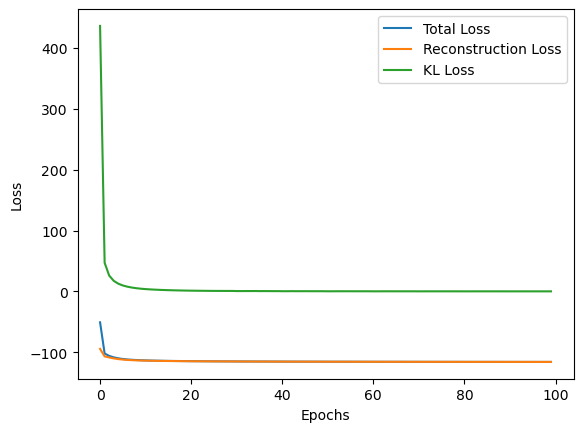

In [16]:
plt.plot(loss_list, label='Total Loss')
plt.plot(recon_loss_list, label='Reconstruction Loss')
plt.plot([l * kl_weight * 10 for l in kl_loss_list], label='KL Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [17]:
HR, LR, SR_up = test_dataset.get_samples(32)
SR = model.sample(LR)

In [20]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

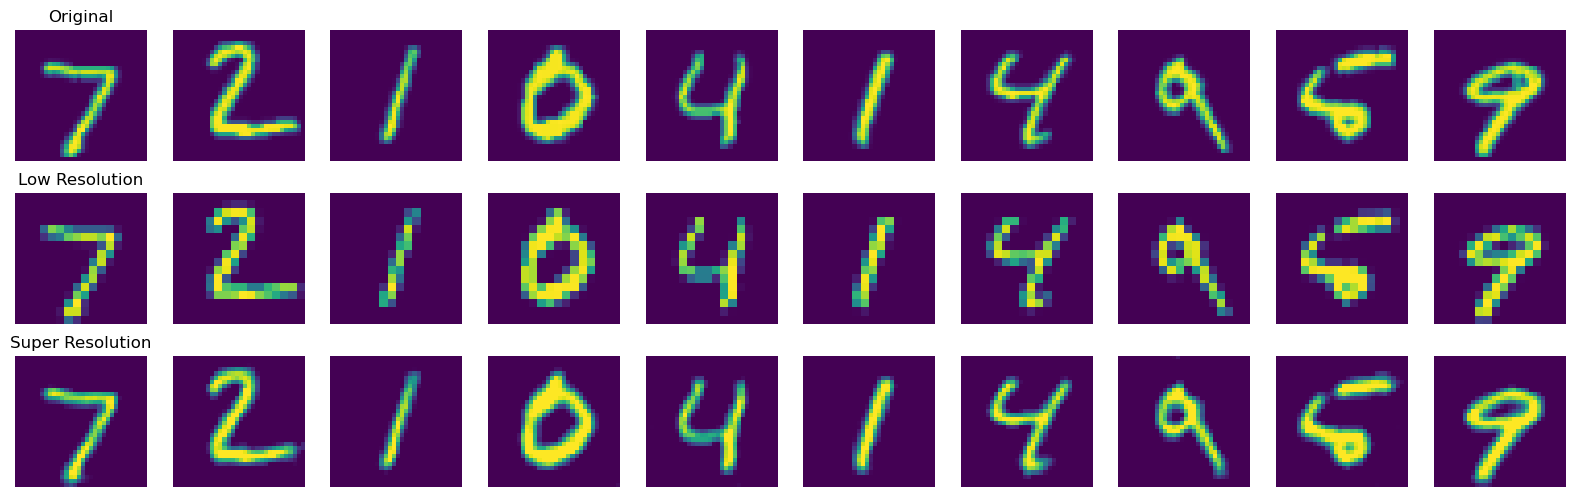

In [21]:
show_image(HR, LR, SR, 10)

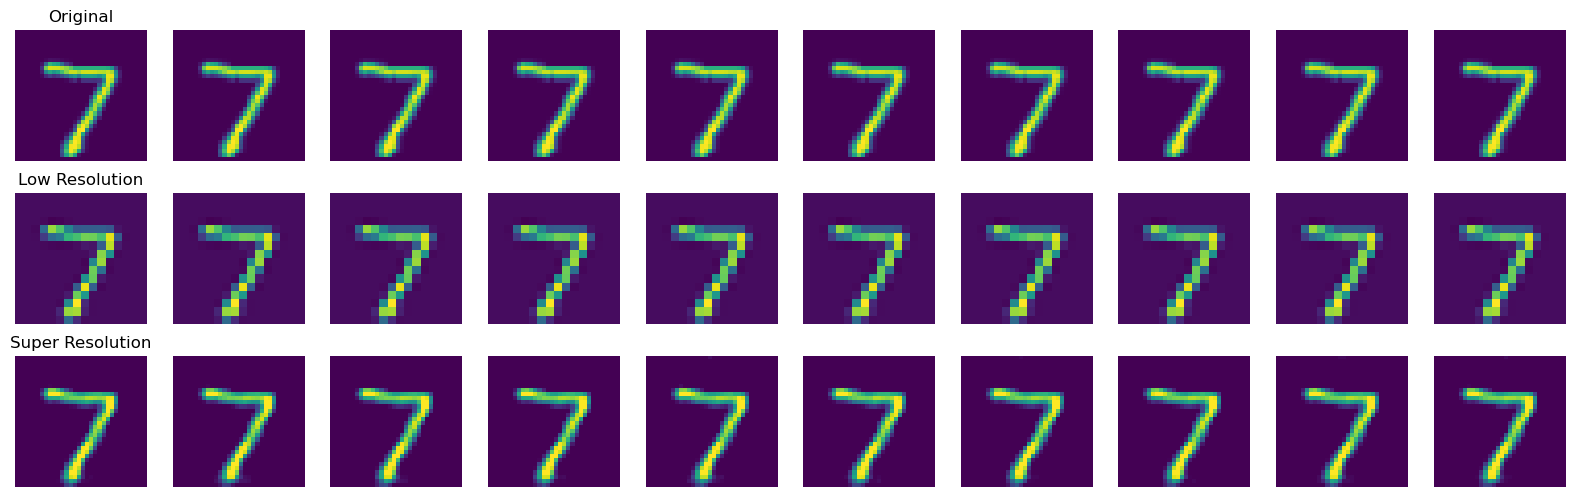

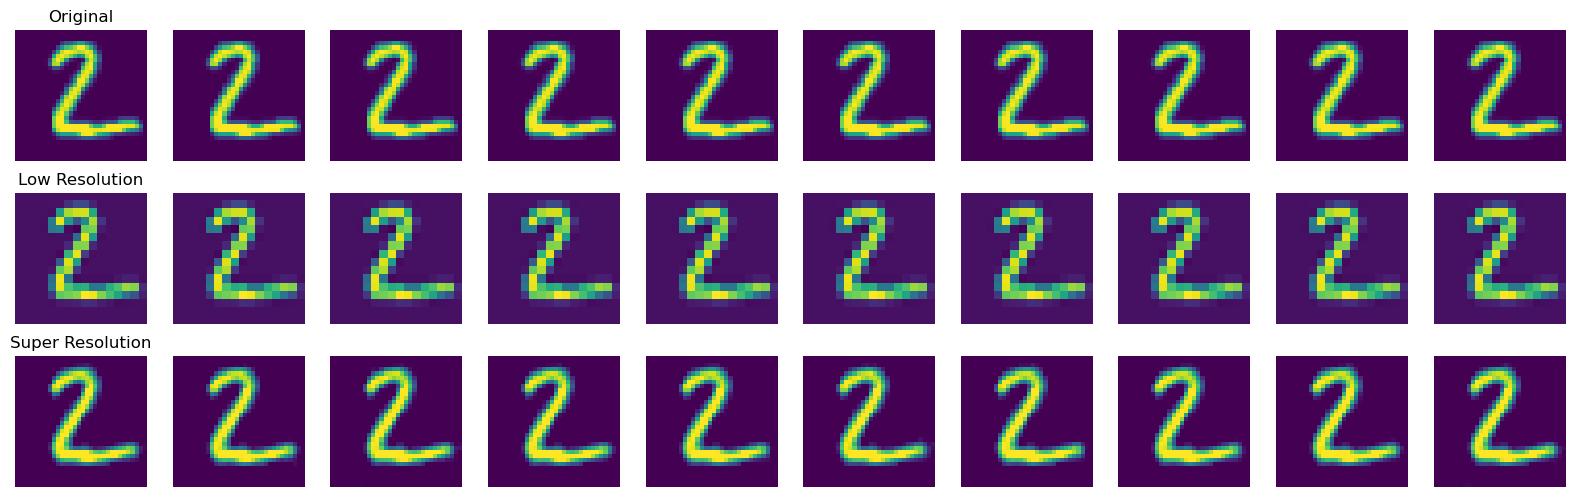

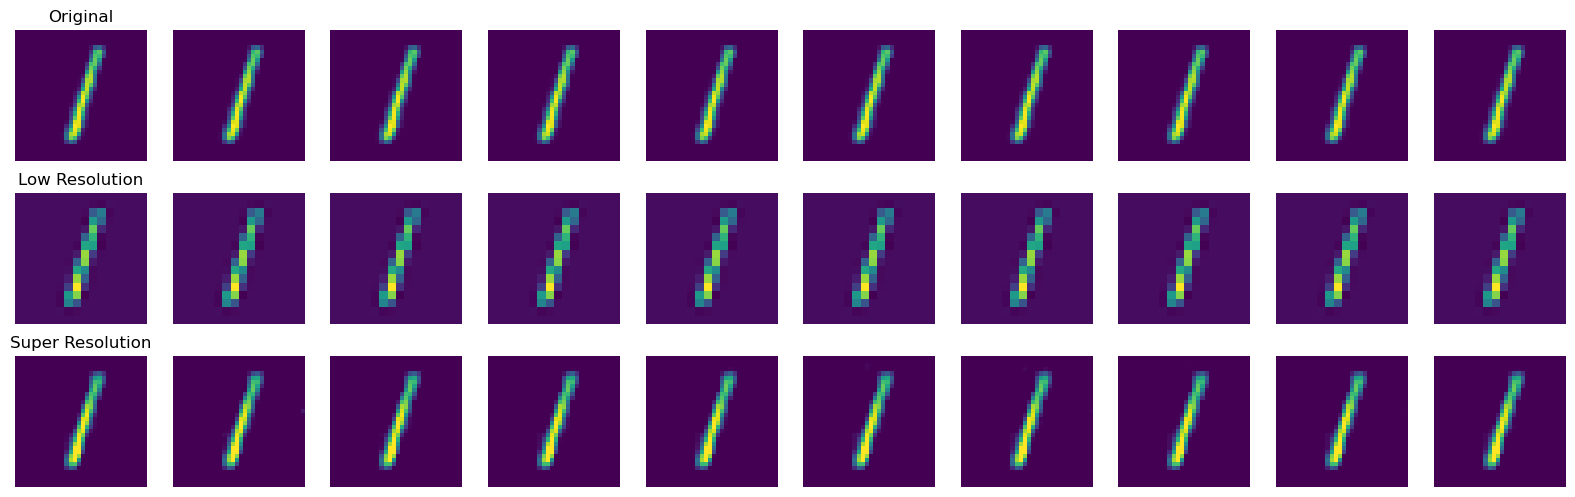

In [22]:
n_samp = 3

for i in range(n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = torch.nn.functional.interpolate(reference, size=(cond_base_width, cond_base_width), mode='bicubic', align_corners=False)
    
    samples = model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 10)

In [23]:
psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

PSNR: 29.760042190551758
SSIM: 0.9850817918777466
LPIPS: 0.016762644052505493
BRISQUE: 72.19477844238281
PSNR Consistency: 29.28731918334961
MSE Diversity: 3.5789167625921436e-05
LPIPS Diversity: 0.0007003307019886051
